# Why would I use UAVSAR for snow?

L-band SAR penetrates through the snowpack. However when it crosses into the snowpack from the air it refracts at an angle, similar to light entering water. This refraction leads to a phase shift relative to an image with no or less snow. Using this difference in phase between two images we can calculate the change in snow height between flights using:

$$
\Delta d = - \frac{\Delta \phi \lambda}{4 \pi} \frac{1}{\cos^{ } \alpha - \sqrt{\epsilon_{s} - \sin^{2} \alpha}}
$$

Where $\Delta$ d is the change in snow height, $\Delta \phi$ is the phase shift between two SAR images, $\lambda$ is the radar wavelength, $\alpha$ is the incidence angle, and $\epsilon_{s}$ is the dielectric constant of snow which is dependent on the density and liquid water content.

:::{figure-md} conceptualfigure
<img src="../../img/uavsar/conceptual.png" style="background-color:white;" alt="conceptual_fig">

Conceptual diagram of radar refraction across the air-snow interface.
:::



## Download test data from GitHub

In [1]:
import os
# clone tifs to tmp directory
os.chdir('/tmp/')
!git clone https://github.com/SnowEx/uavsar-tutorial-data.git

fatal: destination path 'uavsar-tutorial-data' already exists and is not an empty directory.


In [2]:
# list files downloaded
os.chdir('/tmp/uavsar-tutorial-data/')
! ls -l

total 318308
-rw-r--r-- 1 jovyan jovyan 19708218 Jul  7 18:19 cor.tif
drwxr-xr-x 2 jovyan jovyan     4096 Jul  7 18:34 donner_03904_20002-003_20009-026_0019d_s01_L090_01_int_grd
-rw-r--r-- 1 jovyan jovyan 19708218 Jul  7 18:19 inc.tif
-rw-r--r-- 1 jovyan jovyan 21621228 Jul  7 18:19 lowman_amb_db.tif
-rw-r--r-- 1 jovyan jovyan 24901355 Jul  7 18:19 lowman_blue.tif
-rw-r--r-- 1 jovyan jovyan 21647839 Jul  7 18:19 lowman_cor.tif
-rw-r--r-- 1 jovyan jovyan 21383576 Jul  7 18:19 lowman_dem.tif
-rw-r--r-- 1 jovyan jovyan 24975044 Jul  7 18:19 lowman_green.tif
-rw-r--r-- 1 jovyan jovyan 22962409 Jul  7 18:19 lowman_inc_deg.tif
-rw-r--r-- 1 jovyan jovyan 24988038 Jul  7 18:19 lowman_red.tif
-rw-r--r-- 1 jovyan jovyan 64164282 Jul  7 18:33 lowman_rgb.tif
-rw-r--r-- 1 jovyan jovyan 20400596 Jul  7 18:19 lowman_unw.tif
-rw-r--r-- 1 jovyan jovyan    29879 Jul  7 18:19 mesa_snotel.csv
-rw-r--r-- 1 jovyan jovyan       45 Jul  7 18:19 README.md
-rw-r--r-- 1 jovyan jovyan 19708241 Jul  7 18:19 sd_lid

### Import Libraries

In [3]:
# Database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, ImageData, LayerData, SiteData
from snowexsql.conversions import query_to_geopandas

# Uavsar_pytools imports
from uavsar_pytools.snow_depth_inversion import depth_from_phase, phase_from_depth

# Other imports
from os.path import join
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
import rasterio as rio
import rioxarray as rxa
import contextily as cx
%config InlineBackend.figure_format='retina'

### Set variables

In [4]:
# Directory of the uavsar tiffs
data_dir = '/tmp/uavsar-tutorial-data/'

# Mesa Lake Snotel Coordinates
snotel_coords = (-108.05, 39.05)

# February 1st and 13th UAVSAR Image Pairs

You learned in the first section how to access and download UAVSAR imagery. For this section the data has already been downloaded, converted to GeoTiffs and cropped down to an area of interest that overlaps the main field sites of Grand Mesa. Lets take a look at the coherence and unwrapped phase between these two flights. If you don't remember what these two represent check out the previous section of this tutorial.

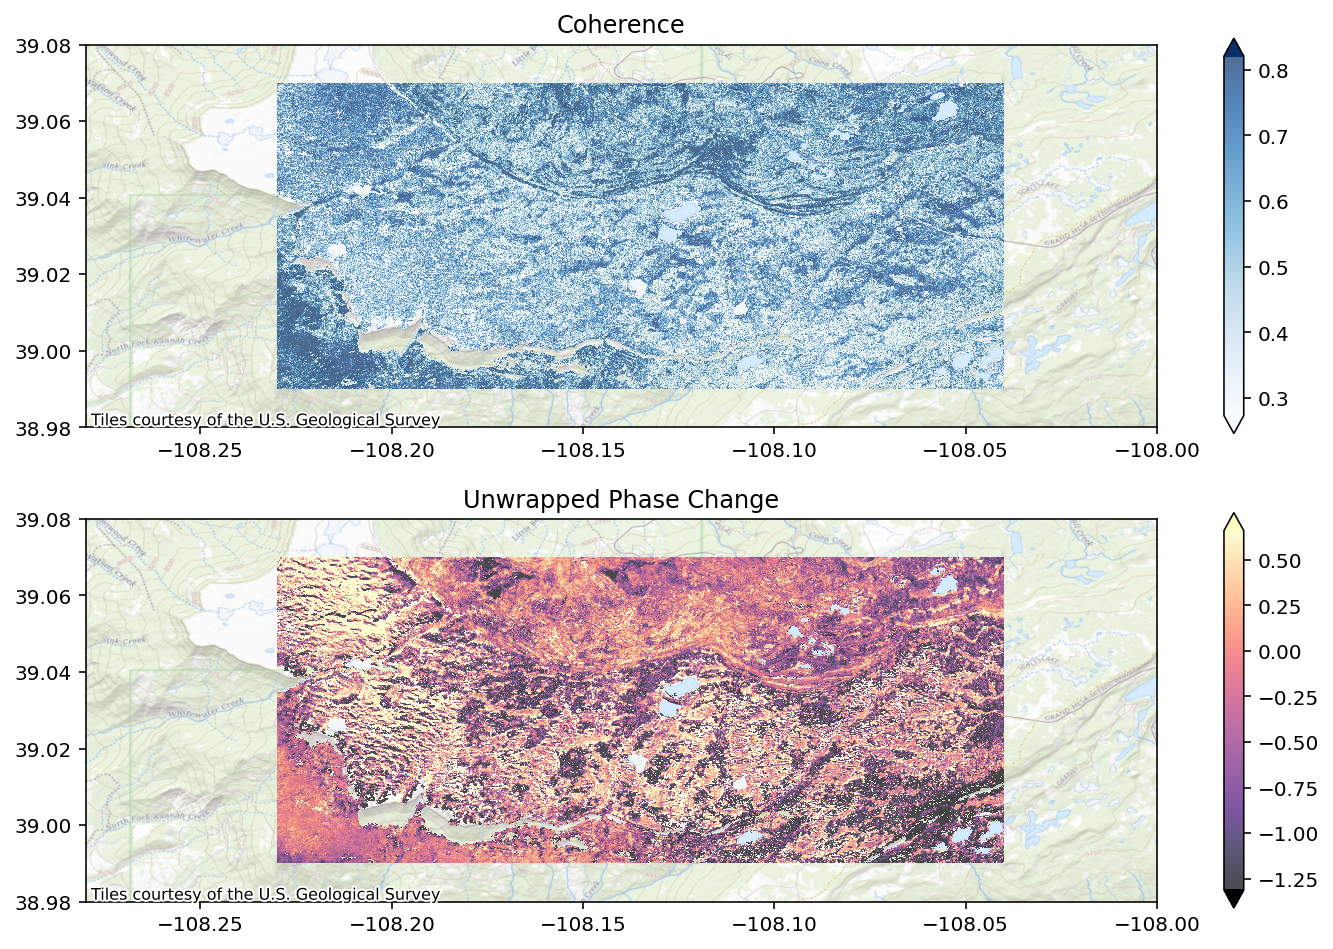

In [5]:
# Create figures and subplots
fig, axes = plt.subplots(2, 1, figsize = (12,8))

# Select colormap for each image type
vis_dic = {'cor': 'Blues', 'unw':'magma'}

for i, type in enumerate(vis_dic.keys()):
    ax = axes[i]
    img = rxa.open_rasterio(join(data_dir, f'{type}.tif'))
    vmin, vmax = img.quantile([0.1,0.9])
    img.plot(ax = ax, vmin = vmin, vmax = vmax, cmap = vis_dic[type], zorder = 1, alpha = 0.7)
    ax.set_xlim(-108.28,-108)
    ax.set_ylim(38.98, 39.08)
    cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo) #cx.providers.USGS.USTopo)
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

axes[0].set_title('Coherence')
axes[1].set_title('Unwrapped Phase Change')

plt.show()

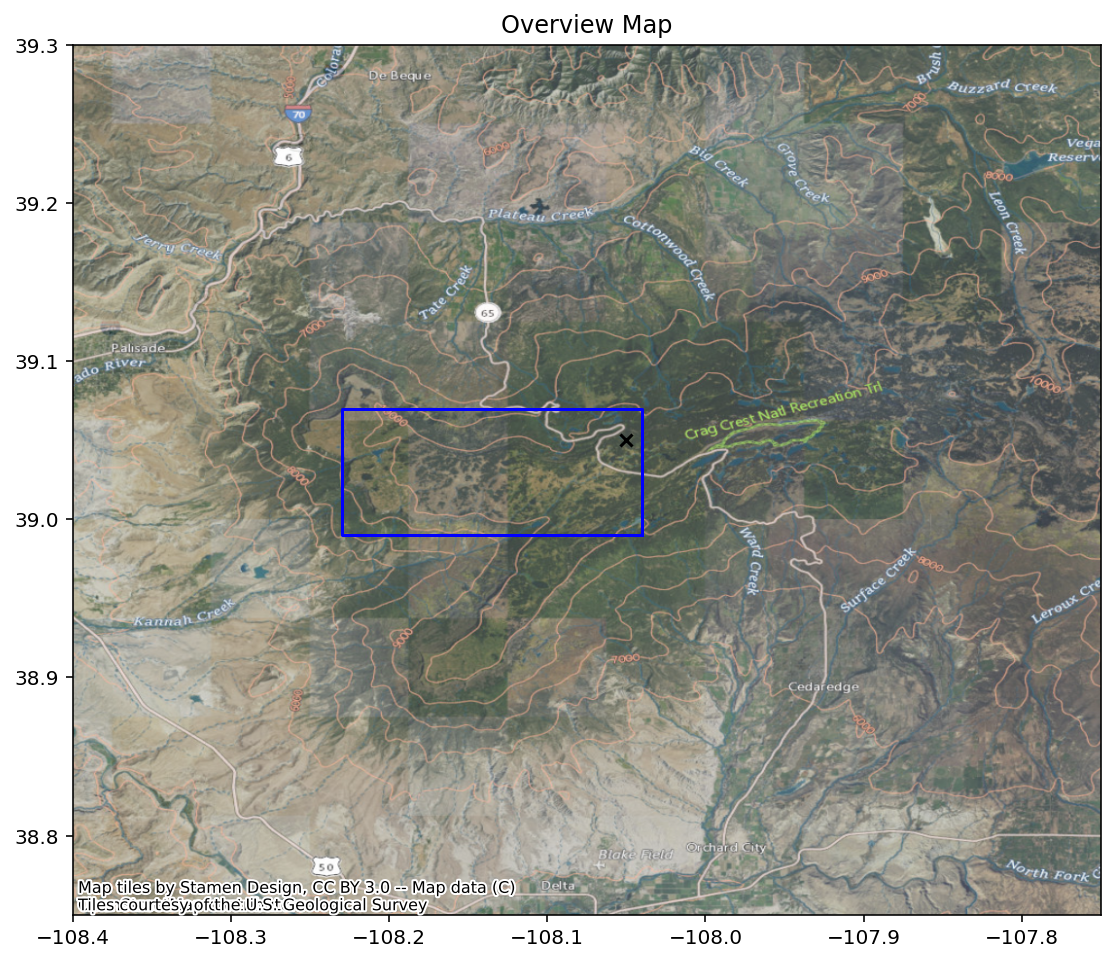

In [6]:
fig, ax = plt.subplots(figsize = (12,8))

# Plot the snotel location
ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')

# Plot bounding box of uavsar
uavsar_bounds = rxa.open_rasterio(join(data_dir, f'cor.tif')).rio.bounds()
x,y = box(*uavsar_bounds).exterior.xy
ax.plot(x,y, color = 'blue')

# Set overview bounds
ax.set_xlim(-108.4,-107.75)
ax.set_ylim(38.75, 39.3)

# Add background map
cx.add_basemap(ax, crs=img.rio.crs, source = cx.providers.Stamen.TerrainLabels)
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
#cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.Stamen.TerrainLabels)
plt.title('Overview Map')
plt.show()

## Using the SnowEx SQL Database to collect snow depth and lidar datasets

In [7]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [8]:
# Its convenient to store a query like the following 
qry = session.query(PointData)

# Filter to snow depths
qry = qry.filter(PointData.type == 'depth')

# Then filter on it first date. We are gonna get one day either side of our flight date
qry_feb1 = qry.filter(PointData.date >= date(2020, 1, 31))
qry_feb1 = qry_feb1.filter(PointData.date <= date(2020, 2, 2))
df_feb_1 = query_to_geopandas(qry_feb1, engine)

# Get depths from second flight date
qry_feb12 = qry.filter(PointData.date >= date(2020, 2, 11))
qry_feb12 = qry_feb12.filter(PointData.date <= date(2020, 2, 13))
df_feb_12 = query_to_geopandas(qry_feb12, engine)

# Get depths that were captured on both days
df_both = df_feb_1.overlay(df_feb_12, how = 'intersection')

# Convert crs to match our uavsar images
df_both = df_both.to_crs(epsg = 4326)

# Calculate the snow depth change for each point
df_both['sd_diff'] = df_both.value_2 - df_both.value_1

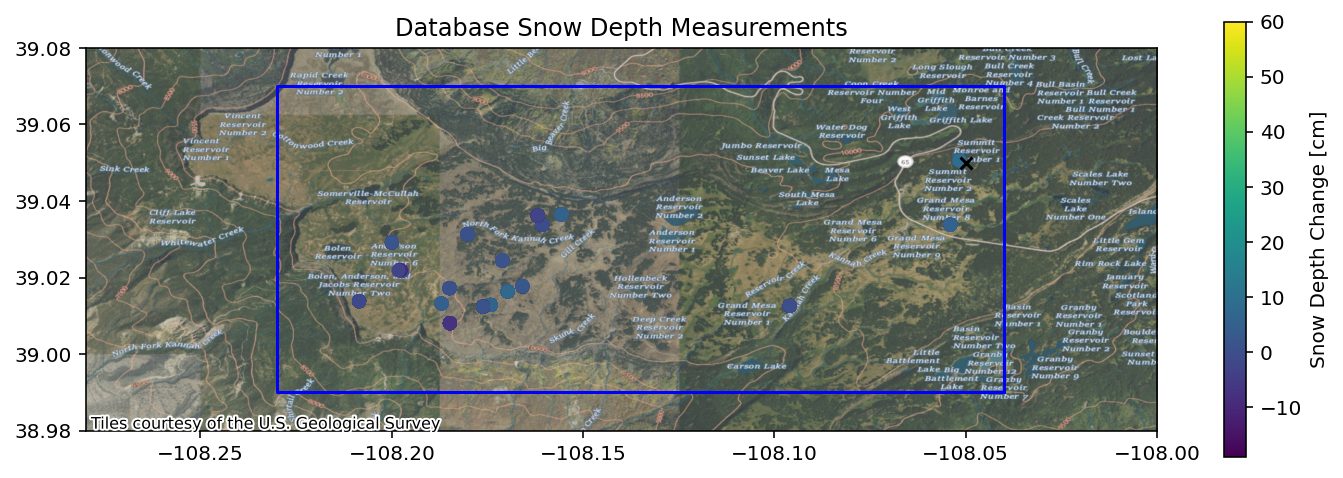

In [9]:
fig, ax = plt.subplots(figsize = (12,4))

# Plot depth measurements
df_both.plot(ax = ax, column = 'sd_diff', legend = True, legend_kwds = {'label': 'Snow Depth Change [cm]'})

# Plot the snotel location
snotel_coords = (-108.05, 39.05)
ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')

# Plot bounding box of uavsar
img = rxa.open_rasterio(join(data_dir, f'cor.tif'))
uavsar_bounds = img.rio.bounds()
x,y = box(*uavsar_bounds).exterior.xy
ax.plot(x,y, color = 'blue')

# Set same bounds as uavsar image plot
ax.set_xlim(-108.28,-108)
ax.set_ylim(38.98, 39.08)

# Add background map
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
plt.title('Database Snow Depth Measurements')
plt.show()

## Snow Depth Change Inversion from Phase

We can recall the formula to calculate snow depth change from incidence angle, phase change, and the snow permittivity. 

$$
\Delta d = - \frac{\Delta \phi \lambda}{4 \pi} \frac{1}{\cos^{ } \alpha - \sqrt{\epsilon_{s} - \sin^{2} \alpha}}
$$

We have two of these variables already: incidence angle and phase change.

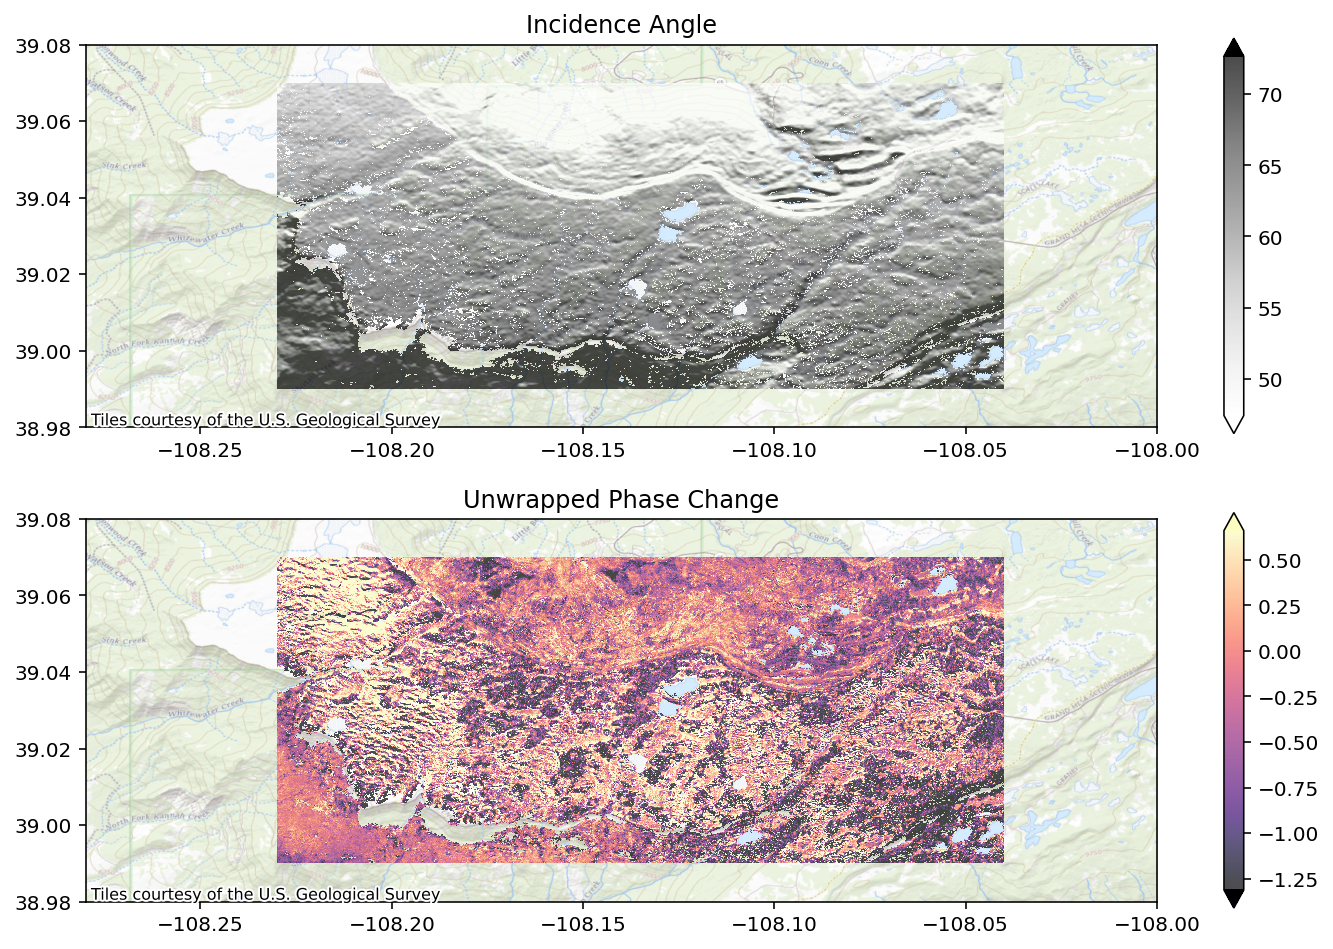

In [10]:
# Create figures and subplots
fig, axes = plt.subplots(2, 1, figsize = (12,8))

# Select colormap for each image type
vis_dic = {'inc': 'Greys', 'unw':'magma'}

for i, type in enumerate(vis_dic.keys()):
    ax = axes[i]
    img = rxa.open_rasterio(join(data_dir, f'{type}.tif'))
    if type == 'inc':
        img = np.rad2deg(img)
    vmin, vmax = img.quantile([0.1,0.9])
    im = img.plot(ax = ax, vmin = vmin, vmax = vmax, cmap = vis_dic[type], zorder = 1, alpha = 0.7)
    ax.set_xlim(-108.28,-108)
    ax.set_ylim(38.98, 39.08)
    cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    
axes[0].set_title('Incidence Angle')
axes[1].set_title('Unwrapped Phase Change')
plt.show()

## Setting the Zero Phase Change point

Unwrapped phase has one unknown - the zero phase point. This means we have an unknown absolute scene wide shift we can control. We will use the snotel depth change between the two flights to set this unknown and get our absolute phase change.

In [11]:
#############################################################
#### zach can you comment the code below a bit more? ########
#############################################################

df = pd.read_csv(join(data_dir, 'mesa_snotel.csv'), skiprows = 3, index_col=['Date'], parse_dates=['Date'])
snotel_sd_delta = (df[df.index == '2020-02-01']['SNWD.I-1 (in) ']*0.0254).values[0] - (df[df.index == '2020-02-12']['SNWD.I-1 (in) ']*0.0254).values[0]
with rio.open(join(data_dir, 'inc.tif')) as src:
    for val in src.sample([snotel_coords]): 
        snotel_inc = val[0]
snotel_sd_phase_from_sd_change = phase_from_depth(snotel_sd_delta, snotel_inc, density = 175)
snotel_coords = (-108.05, 39.05)
with rio.open(join(data_dir, 'unw.tif')) as src:
    for val in src.sample([snotel_coords]): 
        snotel_phase = val[0]
unw = rxa.open_rasterio(join(data_dir, 'unw.tif'))
print(f'Snotel snow depth change: {snotel_sd_delta} cm. Phase should be {snotel_sd_phase_from_sd_change} and is currently {snotel_phase}')
unw = unw - (snotel_phase - snotel_sd_phase_from_sd_change)

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snotel snow depth change: 0.0 cm. Phase should be 0.0 and is currently -0.9738530516624451


We have two ways of getting the $e_{s}$, or the real part of the snow's dielectric permittivity. One is by estimating from the snow density. For dry snow we can estimate the permittivity using the density. There are a number of equations for calculating this value, but we will use the equation from [Guneriussen et al. 2001](https://ieeexplore.ieee.org/document/957273):

$$
e_{s} = 1 + 0.0016 \rho + 1.8 1\mathrm{e}{-9} \rho^{3}
$$

where $e_{s}$ is the real part of the snow's dielectric permittivity and $\rho$ is the density of the new snow accumulated between the two images in $\frac{kg}{m^{3}}$.

The other method is to use the directly measured values for permittivity from the field and averaging the top layer.

In [12]:
# Its convenient to store a query like the following 
qry = session.query(LayerData)

# Filter to snow depths
qry = qry.filter(LayerData.type == 'permittivity')

# Then filter on it first date. We are gonna get one day either side of our flight date
qry = qry.filter(LayerData.date >= date(2020, 1, 31))
qry = qry.filter(LayerData.date <= date(2020, 2, 2))
qry = qry.limit(100)
df = query_to_geopandas(qry, engine)
df

site_name        date                     time_created time_updated  \
0   Senator Beck  2020-02-01 2022-06-30 22:44:08.099526+00:00         None   
1   Senator Beck  2020-02-01 2022-06-30 22:44:08.099526+00:00         None   
2   Senator Beck  2020-02-01 2022-06-30 22:44:08.099526+00:00         None   
3   Senator Beck  2020-02-01 2022-06-30 22:44:08.099526+00:00         None   
4   Senator Beck  2020-02-01 2022-06-30 22:44:08.099526+00:00         None   
..           ...         ...                              ...          ...   
95    Grand Mesa  2020-02-01 2022-06-30 22:28:43.516244+00:00         None   
96    Grand Mesa  2020-02-01 2022-06-30 22:28:43.516244+00:00         None   
97    Grand Mesa  2020-02-01 2022-06-30 22:28:43.516244+00:00         None   
98    Grand Mesa  2020-02-01 2022-06-30 22:28:43.516244+00:00         None   
99    Grand Mesa  2020-02-01 2022-06-30 22:28:43.516244+00:00         None   

       id                                   doi date_accessed instrument  \
0   53747                                  None    2022-06-30       None   
1   53748                                  None    2022-06-30       None   
2   53749                                  None    2022-06-30       None   
3   53750                                  None    2022-06-30       None   
4   53751                                  None    2022-06-30       None   
..    ...                                   ...           ...        ...   
95  10021  https://doi.org/10.5067/DUD2VZEVBJ7S    2022-06-30       None   
96  10022  https://doi.org/10.5067/DUD2VZEVBJ7S    2022-06-30       None   
97  10023  https://doi.org/10.5067/DUD2VZEVBJ7S    2022-06-30       None   
98  10024  https://doi.org/10.5067/DUD2VZEVBJ7S    2022-06-30       None   
99  10025  https://doi.org/10.5067/DUD2VZEVBJ7S    2022-06-30       None   

            type units  ...  depth       site_id                pit_id  \
0   permittivity  None  ...  111.0  Senator Beck  COSBSB_20200201_0950   
1   permittivity  None  ...  101.0  Senator Beck  COSBSB_20200201_0950   
2   permittivity  None  ...   91.0  Senator Beck  COSBSB_20200201_0950   
3   permittivity  None  ...   81.0  Senator Beck  COSBSB_20200201_0950   
4   permittivity  None  ...   71.0  Senator Beck  COSBSB_20200201_0950   
..           ...   ...  ...    ...           ...                   ...   
95  permittivity  None  ...   63.0          9N44     COGM9N44_20200201   
96  permittivity  None  ...   53.0          9N44     COGM9N44_20200201   
97  permittivity  None  ...   43.0          9N44     COGM9N44_20200201   
98  permittivity  None  ...   33.0          9N44     COGM9N44_20200201   
99  permittivity  None  ...   23.0          9N44     COGM9N44_20200201   

    bottom_depth  comments sample_a  sample_b sample_c  value  flags  
0          101.0      None     None      None     None   None  STCom  
1           91.0      None     None      None     None   None  STCom  
2           81.0      None     None      None     None   None  STCom  
3           71.0      None     None      None     None   None  STCom  
4           61.0      None     None      None     None   None  STCom  
..           ...       ...      ...       ...      ...    ...    ...  
95          53.0      None    1.443     1.443     None  1.443   None  
96          43.0      None    1.516     1.516     None  1.516   None  
97          33.0      None    1.653     1.653     None  1.653   None  
98          23.0      None    1.667     1.667     None  1.667   None  
99          13.0      None    1.572     1.572     None  1.572   None  

[100 rows x 29 columns]

In [13]:
for id in np.unique(df.site_id):
    sub = df[df.site_id == id]
    es = float(sub.sort_values(by = 'depth', ascending = False).iloc[0]['value'])
    es_values.append(es)
    
mean_new_snow_es = np.nanmean(es_values)

NameError: name 'es_values' is not defined

In [ ]:
# Its convenient to store a query like the following 
qry = session.query(LayerData)

# Then filter on it first date. We are gonna get one day either side of second flight date
qry = qry.filter(LayerData.date >= date(2020, 1, 31))
qry = qry.filter(LayerData.date <= date(2020, 2, 2))

# Filter to snow density

### comment this too? 
qry_p = qry.filter(LayerData.type == 'density')
df = query_to_geopandas(qry_p, engine)
p_values = []
for id in np.unique(df.site_id):
    sub = df[df.site_id == id]
    p = float(sub.sort_values(by = 'depth', ascending = False).iloc[0]['value'])
    p_values.append(p)
mean_new_density = np.nanmean(p_values)
density_new_permittivity = 1 + 0.0016*mean_new_density + 1.8e-09*mean_new_density**3

qry = qry.filter(LayerData.type == 'permittivity')
df = query_to_geopandas(qry, engine)
es_values = []
for id in np.unique(df.site_id):
    sub = df[df.site_id == id]
    es = float(sub.sort_values(by = 'depth', ascending = False).iloc[0]['value'])
    es_values.append(es)
mean_new_permittivity = np.nanmean(es_values)

print(f'New snow measured permittivity: {mean_new_permittivity}. Permittivity from density: {density_new_permittivity}')

In [ ]:
unw = rxa.open_rasterio(join(data_dir, f'unw.tif'))
inc = rxa.open_rasterio(join(data_dir, f'inc.tif'))
# sd_change = depth_from_phase(unw, inc, permittivity = mean_new_snow_es)
sd_change = depth_from_phase(unw, inc, density = mean_new_density)
sd_change = sd_change*100

In [ ]:
f, ax = plt.subplots(figsize = (12,8))

sd_change.plot(ax = ax, cmap = 'Blues', vmin = -10, vmax = 10)

df_both.plot(ax = ax, color = 'black', markersize = 90)
df_both.plot(ax = ax, column = 'sd_diff', legend = True, cmap = 'Blues', vmin = -10, vmax = 10)
ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_title('Uavsar Snow Depth Inversion vs Field Observations')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize = (12,8))

sd_change.plot(ax = ax, cmap = 'Blues', vmin = -10, vmax = 10)

df_both.plot(ax = ax, color = 'black', markersize = 90)
df_both.plot(ax = ax, column = 'sd_diff', legend = True, cmap = 'Blues', vmin = -10, vmax = 10)
ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_title('Uavsar Snow Depth Inversion vs Field Observations')
ax.set_xlim(-108.14, -108.23)
ax.set_ylim(39, 39.05)
plt.show()

In [ ]:
sd_change_fp = join(data_dir,'gm_phase_dz.tif')
sd_change.rio.to_raster(sd_change_fp)
with rio.open(sd_change_fp) as src:
    coord_list = [(x,y) for x,y in zip(df_both['geometry'].x , df_both['geometry'].y)]
    df_both['uavsar_sd'] = [x[0] for x in src.sample(coord_list)]

f, ax = plt.subplots(figsize = (12,8))
df_both['geometry-str'] = df_both['geometry'].astype(str)
df_dis = df_both.dissolve('geometry-str', aggfunc = 'mean')
field_sd_std = df_both.dissolve('geometry-str', aggfunc = 'std')['sd_diff'].values
ax.errorbar(x = df_dis.uavsar_sd, y = df_dis.sd_diff, yerr = field_sd_std, fmt="o")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

## Comparison to Lidar

In [ ]:
# Create figures and subplots
fig, axes = plt.subplots(3, 1, figsize = (12,8))

lidar = rxa.open_rasterio(join(data_dir, 'sd_lidar.tif'))

diff = lidar.copy()
diff = diff - sd_change

vmin, vmax = sd_change.quantile([0.1,0.9])
sd_change_masked = sd_change.copy()
sd_change_masked.data[np.isnan(lidar).data] = np.nan
sd_change_masked.plot(ax = axes[0], vmin = vmin, vmax = vmax, cmap = 'Blues', zorder = 1, alpha = 0.7)
lidar.plot(ax = axes[1], vmin = vmin, vmax = vmax, cmap = 'Blues', zorder = 1, alpha = 0.7)
diff.plot(ax = axes[2], vmin = vmin, vmax = vmax, cmap = 'Blues', zorder = 1, alpha = 0.7)

for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

axes[0].set_title('Uavsar Snow Depth Change')
axes[1].set_title('Lidar Snow Depth Change')
axes[2].set_title('Snow Depth Difference')
plt.tight_layout()
plt.show()

In [ ]:
diffs = diff.values.ravel()
diffs = diffs[diffs < 100]
diffs = diffs[diffs > -100]
plt.hist(diffs, bins = 100, density = True)
# plt.axvline(sd_change_masked.mean().values, label = 'Uavsar Mean Snow Depth Change', color = 'green')
lidar_vals = lidar.astype(np.float64).values[~lidar.isnull().values]
lidar_vals = lidar_vals[lidar_vals < 100]
lidar_vals = lidar_vals[lidar_vals > -100]
mean_lidar = np.nanmean(lidar_vals)
# plt.axvline(mean_lidar, label = 'Lidar Mean Snow Depth Change', color = 'red')
rmse = np.sqrt(((diffs) ** 2).mean())
print(f'Lidar mean depth change: {sd_change_masked.mean().values} cm, uavsar mean depth change: {mean_lidar} cm')
print(f'Mean difference: {np.nanmean(diffs)} cm, rmse = {rmse} cm')
# plt.legend()
plt.show()